## GoogLeNet in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

import os
import pathlib
import zipfile
import shutil

### Data Preparation

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -p /content/datasets  -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
root = pathlib.Path('/content/datasets')

In [7]:
if not os.path.exists(root / 'dogs-vs-cats'):
  with zipfile.ZipFile(root / 'dogs-vs-cats.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')
      
  with zipfile.ZipFile(root / 'dogs-vs-cats/train.zip', 'r') as zip_ref:
      zip_ref.extractall(root / 'dogs-vs-cats')


In [8]:
original_path = root / 'dogs-vs-cats'
new_path = root / 'dogs_vs_cats_prepared'

In [9]:
# prepare list of files
file_names = os.listdir(original_path / 'train')
test_file_names = file_names[0:5000]
val_file_names = file_names[5000:10000]
train_file_names = file_names[10000:]

In [10]:
# prepare dirs
for directory in ["train", "test", "val"]:
    for category in ["cat", "dog"]:
        new_dir = new_path / directory / category
        if os.path.exists(new_dir):
            shutil.rmtree(new_dir)
        os.makedirs(new_dir)

In [11]:
def copy_files(old_dir, new_dir, files_list):
    for idx, filename in enumerate(files_list):
        src = old_dir / filename
        if filename.startswith('cat'):
            dst = new_dir / 'cat' / filename
        elif filename.startswith('dog'):
            dst = new_dir / 'dog' / filename
        else:
            continue
            
        shutil.copyfile(src=src, dst=dst)

In [12]:
copy_files(old_dir=original_path / "train", new_dir=new_path / 'train', files_list=train_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'val', files_list=val_file_names)
copy_files(old_dir=original_path / "train", new_dir=new_path / 'test', files_list=test_file_names)

In [13]:
root = new_path

In [14]:
train_transform = T.Compose([T.Resize((256, 256)), 
                             T.RandomCrop(size=(224, 224)),
                             T.ToTensor()])

test_transform = T.Compose([T.Resize((224, 224)), 
                                T.ToTensor()])

In [15]:
train_dataset = ImageFolder(root=root / 'train', transform=train_transform)
val_dataset = ImageFolder(root=root / 'val', transform=test_transform)
test_dataset = ImageFolder(root=root / 'test', transform=test_transform)

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128

In [17]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

### Model Creation and Training


In [18]:
class BasicBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               **kwargs):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_channels, 
                  bias=False,
                  **kwargs),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU())
  
  def forward(self, x):
    return self.block(x)

In [19]:
class InceptionBlock(nn.Module):

    def __init__(self, 
                 in_channels, 
                 conv1x1_channels,
                 conv3x3_input_channels,
                 conv3x3_channels,
                 conv5x5_input_channels,
                 conv5x5_channels,
                 projection_channels):
        super().__init__()
        
        self.branch_1 = BasicBlock(in_channels=in_channels, 
                                  out_channels=conv1x1_channels,
                                  kernel_size=1)
        
        self.branch_2 = nn.Sequential(
            BasicBlock(in_channels=in_channels,
                        out_channels=conv3x3_input_channels,
                        kernel_size=1),
            BasicBlock(in_channels=conv3x3_input_channels,
                        out_channels=conv3x3_channels,
                        kernel_size=3,
                        padding=1))
        
        self.branch_3 = nn.Sequential(
            BasicBlock(in_channels=in_channels, 
                       out_channels=conv5x5_input_channels,
                       kernel_size=1),
            BasicBlock(in_channels=conv5x5_input_channels,
                       out_channels=conv5x5_channels,
                       kernel_size=5,
                       padding=2))
        
        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicBlock(in_channels, projection_channels, kernel_size=1),
        )

        
    def forward(self, x):
        return torch.cat([self.branch_1(x), 
                          self.branch_2(x), 
                          self.branch_3(x), 
                          self.branch_4(x)], dim=1)

In [20]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_1 = BasicBlock(in_channels=3, 
                            out_channels=64, 
                            kernel_size=7, 
                            stride=2,
                            padding=3)
    
    self.max_pool_1 = nn.MaxPool2d(kernel_size=3, 
                                   stride=2, 
                                   ceil_mode=True)

    self.conv_2 = BasicBlock(in_channels=64, 
                            out_channels=64,
                            kernel_size=1)

    self.conv_3 = BasicBlock(in_channels=64, 
                            out_channels=192, 
                            kernel_size=3, 
                            stride=1,
                            padding=1)
    
    self.max_pool_2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
    
    self.inception_3a = InceptionBlock(
        in_channels=192, 
        conv1x1_channels=64,
        conv3x3_input_channels=96,
        conv3x3_channels=128,
        conv5x5_input_channels=16,
        conv5x5_channels=32,
        projection_channels=32)
    
    self.inception_3b = InceptionBlock(
        in_channels=256, 
        conv1x1_channels=128,
        conv3x3_input_channels=128,
        conv3x3_channels=192,
        conv5x5_input_channels=32,
        conv5x5_channels=96,
        projection_channels=64)
    
    self.max_pool_3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # small kernel outputs decrease, large kernel outputs increase
    # the overall number of channels is constant from 4a - 4c
    self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
    self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
    self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
    self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
    self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

    self.max_pool_4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
    self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p=0.4)
    self.fc = nn.Linear(1024, 1)


  def forward(self, x):
    # 3, 224, 224
    x = self.conv_1(x)
    # 64, 112, 112 
    x = self.max_pool_1(x)
    # 64, 56, 56
    x = self.conv_2(x)
    # 64, 56, 56
    x = self.conv_3(x)
    # 192, 56, 56
    x = self.max_pool_2(x)
    # 192, 28, 28
    x = self.inception_3a(x)
    # 256, 28, 28
    x = self.inception_3b(x)
    # 480, 28, 28
    x = self.max_pool_3(x)
    # 480, 14, 14
    x = self.inception_4a(x)
    x = self.inception_4b(x)
    x = self.inception_4c(x)
    # 512, 14, 14
    x = self.inception_4d(x)
    # 528, 14, 14
    x = self.inception_4e(x)
    # 832, 14, 14
    x = self.max_pool_4(x)
    # 832, 7, 7
    x = self.inception_5a(x)
    # 832, 7, 7
    x = self.inception_5b(x)
    # 1024, 7, 7
    x = self.avgpool(x)
    # 1024, 1, 1
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [21]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE).view(-1, 1).float()
            logits = model(features)
            probs = torch.sigmoid(logits)
                        
            predictions = (probs > 0.5).float()
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [22]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [23]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            labels = labels = labels.to(DEVICE).view(-1, 1).float()
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            logits = model(features)
            
            # Calculate Loss
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
        
        if scheduler:
          scheduler.step(val_loss)
    return history

In [24]:
model = Model()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.00382 | Val Loss: 0.00418 | Train Acc: 0.763 | Val Acc: 0.747
Epoch:  2/10 | Train Loss: 0.00466 | Val Loss: 0.00485 | Train Acc: 0.667 | Val Acc: 0.647
Epoch:  3/10 | Train Loss: 0.00384 | Val Loss: 0.00431 | Train Acc: 0.760 | Val Acc: 0.734
Epoch:  4/10 | Train Loss: 0.00312 | Val Loss: 0.00358 | Train Acc: 0.814 | Val Acc: 0.784
Epoch:  5/10 | Train Loss: 0.00164 | Val Loss: 0.00214 | Train Acc: 0.910 | Val Acc: 0.884
Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  6/10 | Train Loss: 0.00088 | Val Loss: 0.00150 | Train Acc: 0.958 | Val Acc: 0.922
Epoch:  7/10 | Train Loss: 0.00071 | Val Loss: 0.00144 | Train Acc: 0.967 | Val Acc: 0.926
Epoch:  8/10 | Train Loss: 0.00058 | Val Loss: 0.00141 | Train Acc: 0.974 | Val Acc: 0.926
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  9/10 | Train Loss: 0.00053 | Val Loss: 0.00138 | Train Acc: 0.976 | Val Acc: 0.931
Epoch: 10/10 | Train Loss: 0.00050 | Val Loss: 0.00138 | 

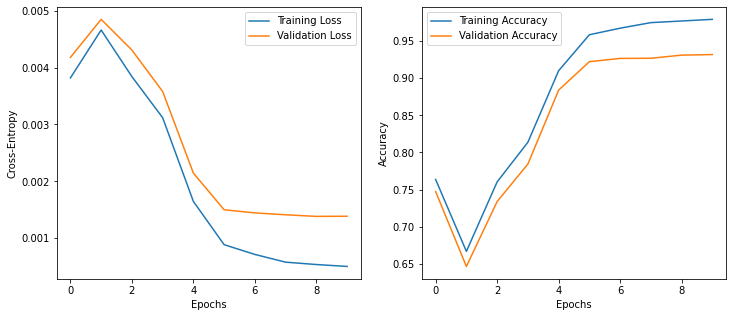

In [ ]:
plot_history(history)

### Transfer Learning


In [25]:
from torchvision.models import googlenet, GoogLeNet_Weights

In [26]:
model = googlenet(weights=GoogLeNet_Weights, progress=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
for param in model.parameters():
  param.requires_grad = False

In [28]:
model.fc = nn.Linear(in_features=1024, out_features=1)

In [29]:
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       patience=2,
                                                       verbose=True)
criterion = nn.BCEWithLogitsLoss()

In [30]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer, scheduler)

Epoch:  1/10 | Train Loss: 0.00068 | Val Loss: 0.00069 | Train Acc: 0.973 | Val Acc: 0.974
Epoch:  2/10 | Train Loss: 0.00056 | Val Loss: 0.00056 | Train Acc: 0.978 | Val Acc: 0.978
Epoch:  3/10 | Train Loss: 0.00052 | Val Loss: 0.00052 | Train Acc: 0.978 | Val Acc: 0.979
Epoch:  4/10 | Train Loss: 0.00049 | Val Loss: 0.00049 | Train Acc: 0.978 | Val Acc: 0.979
Epoch 00004: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  5/10 | Train Loss: 0.00048 | Val Loss: 0.00049 | Train Acc: 0.979 | Val Acc: 0.979
Epoch:  6/10 | Train Loss: 0.00048 | Val Loss: 0.00049 | Train Acc: 0.979 | Val Acc: 0.979
Epoch:  7/10 | Train Loss: 0.00047 | Val Loss: 0.00048 | Train Acc: 0.980 | Val Acc: 0.979
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  8/10 | Train Loss: 0.00048 | Val Loss: 0.00049 | Train Acc: 0.979 | Val Acc: 0.979
Epoch:  9/10 | Train Loss: 0.00047 | Val Loss: 0.00049 | Train Acc: 0.980 | Val Acc: 0.979
Epoch: 10/10 | Train Loss: 0.00048 | Val Loss: 0.00048 | 

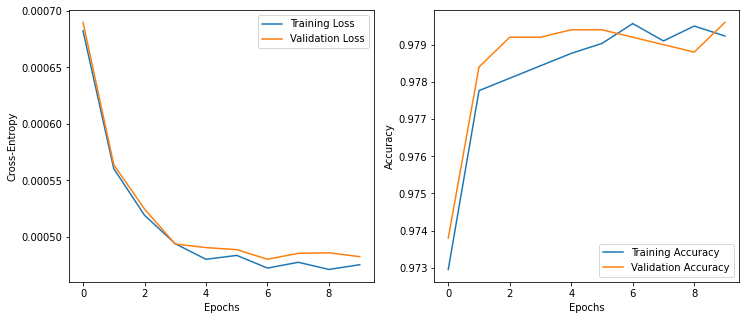

In [31]:
plot_history(history)